# IMPLEMENTASI DEEP LEARNING UNTUK IMAGE CLASSIFICATION MENGGUNAKAN ALGORITMA CONVOLUTIONAL NEURAL NETWORK (CNN) PADA CITRA WAYANG KULIT

Tahapan yang dilakukan dalam proses klasifikasi sebagai berikut :
1. Import Library yang dibutuhkan
2. Memuat Dataset berupa Citra Wayang Kulit
3. Membuat Model CNN dan on top VGG yang akan di evaluasi performanya
4. Melakukan Train ulang dan mengevaluasi ulang dari Model sebelumnya



# Importing Library

In [1]:
# import File citra dari drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import library yang dibutuhkan
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf 
from tqdm import tqdm
import random
from random import randrange

In [3]:
# membuat label citra yang akan di klasifikasi
class_names = ['arjuna', 'bagong', 'bathara surya', 'bathara wisnu', 'gareng', 
               'nakula', 'sadewa', 'petruk', 'semar', 'werkudara', 'yudistira']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
IMAGE_SIZE = (150, 150) # menentukan ukuran citra

# Memuat Dataset

In [4]:
# membuat fungsi load_data untuk memuat data citra dan data label dari folder dataset
def load_data():
    datasets = ['/content/drive/MyDrive/Klasifikasi Wayang Kulit/dataset/train', 
                '/content/drive/MyDrive/Klasifikasi Wayang Kulit/dataset/test'] 
    output = []
    # perulangan melalui training dan tes citra
    for dataset in datasets:
        images = []
        labels = []
        print("Memuat {}".format(dataset))
        #  perulangan setiap folder untuk mendapatkan kategori
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            # perulangan setiap citra yang ada di folder dataset
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                # mendapatkan nama-nama citra
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # membuka dan merubah ukuran citra
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                # menambahkan citra dan label sesuai output
                images.append(image)
                labels.append(label)
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')  
        output.append((images, labels))
    return output
# menampilkan proses memuat citra dari dataset
(train_images, train_labels), (test_images, test_labels) = load_data()
train_images, train_labels = shuffle(train_images, train_labels, random_state=10)

Memuat /content/drive/MyDrive/Klasifikasi Wayang Kulit/dataset/train


100%|██████████| 250/250 [02:29<00:00,  1.67it/s]


Memuat /content/drive/MyDrive/Klasifikasi Wayang Kulit/dataset/test


100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


# Melihat Jumlah Citra

In [5]:
n_train = train_labels.shape[0] # menghitung jumlah citra train
n_test = test_labels.shape[0] # menghitung jumlah citra test

print ("Jumlah citra training : {}".format(n_train))
print ("Jumlah citra testing : {}".format(n_test))
print ("Ukuran citra : {}".format(IMAGE_SIZE))

Jumlah citra training : 1850
Jumlah citra testing : 330
Ukuran citra : (150, 150)


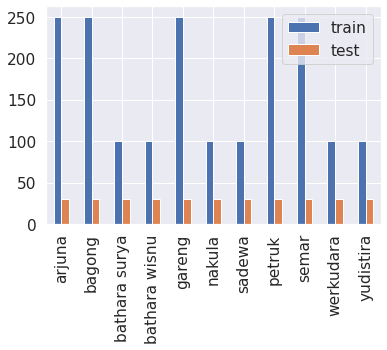

In [6]:
# membuat diagram batang
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts, 'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.savefig('/content/drive/MyDrive/Klasifikasi Wayang Kulit/asset_e10/plot_dataset.png')
plt.show()

In [7]:
# melakukan scale citra
train_images = train_images / 255.0 
test_images = test_images / 255.0

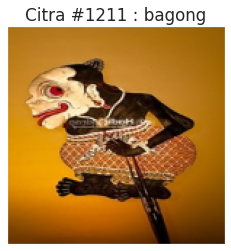

In [8]:
# menampilkan satu citra acak dari data training
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Citra #{} : '.format(index) + class_names[labels[index]])
    plt.show()
display_random_image(class_names, train_images, train_labels)

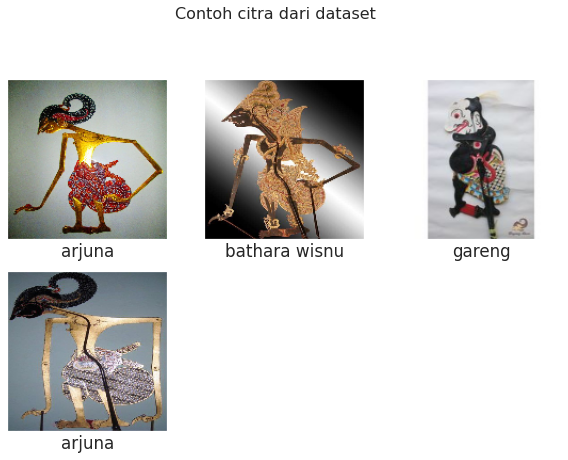

In [9]:
# menampilkan 5 citra dari data training
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Contoh citra dari dataset", fontsize=16)
    for i in range(4):
        plt.subplot(3,3,i+1)  
        #plt.subplot(5,5,i+1)  
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
display_examples(class_names, train_images, train_labels)

# Membuat Model CNN

Tahapan yang dilakukan :
1. Membangun model
2. Menyusun Model
3. Training data citra
4. Mengevaluasi model pada set pengujian
5. Melakukan analisa kesalahan model

Model lapisan pengujian :
* Conv2D:(32 dan 64 filter citra 3x3) Fitur akan diektrak dari citra
* MaxPooling2D: Citra menjadi setengah ukuran
* Flatten: Merubah format citra 2d ke 1d dengan nilai 150 150 3 piksel
* Relu : memberikan nilai x, mengembalikan maks(x, 0)
* Softmax: 11 neurons, probabilitas bahwa citra termasuk dalam salah satu kelas

In [10]:
%%time

import time
from time import time
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

#Training model Sequensial
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', 
                           input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(11, activation=tf.nn.softmax)
])
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               10616960  
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1

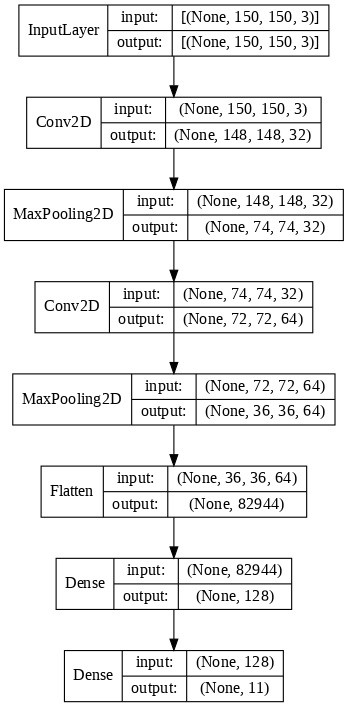

In [11]:
plot_model(model, to_file='/content/drive/MyDrive/Klasifikasi Wayang Kulit/asset_e10/model_Sequential.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80)

In [12]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
12/12 [==============================] - 39s 3s/step - loss: 4.2192 - accuracy: 0.1331 - val_loss: 2.1268 - val_accuracy: 0.3486
Epoch 2/10
12/12 [==============================] - 37s 3s/step - loss: 1.6575 - accuracy: 0.5081 - val_loss: 1.0331 - val_accuracy: 0.6919
Epoch 3/10
12/12 [==============================] - 36s 3s/step - loss: 0.6625 - accuracy: 0.8061 - val_loss: 0.4589 - val_accuracy: 0.9054
Epoch 4/10
12/12 [==============================] - 37s 3s/step - loss: 0.2292 - accuracy: 0.9493 - val_loss: 0.2004 - val_accuracy: 0.9568
Epoch 5/10
12/12 [==============================] - 36s 3s/step - loss: 0.0862 - accuracy: 0.9804 - val_loss: 0.1475 - val_accuracy: 0.9622
Epoch 6/10
12/12 [==============================] - 38s 3s/step - loss: 0.0316 - accuracy: 0.9932 - val_loss: 0.1328 - val_accuracy: 0.9676
Epoch 7/10
12/12 [==============================] - 37s 3s/step - loss: 0.0277 - accuracy: 0.9932 - val_loss: 0.1473 - val_accuracy: 0.9730
Epoch 8/10
12/12 [==

In [13]:
# simpan model
filename = '/content/drive/MyDrive/Klasifikasi Wayang Kulit/model_e10/model_Sequensial.h5'
model.save(filename)
#print('>Saved model to %s' % filename)

# simpan model report ke csv
model_csv = pd.DataFrame(history.history)
csv_file = '/content/drive/MyDrive/Klasifikasi Wayang Kulit/model_e10/model_Sequensial.csv'
with open(csv_file, mode="w") as f:
  model_csv.to_csv(f)
#print('>Saved report to %s' % csv_file)

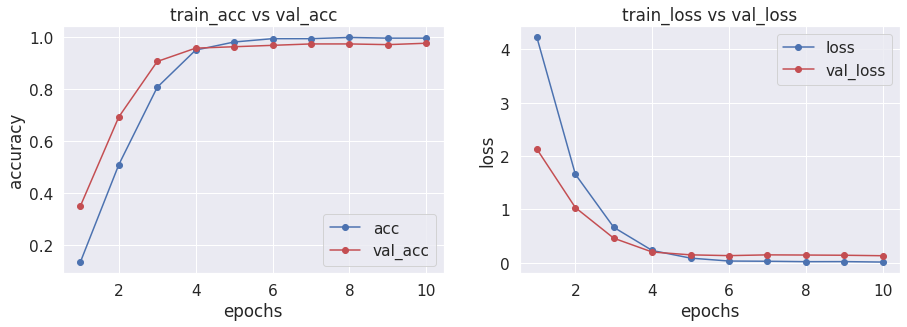

In [14]:
def plot_accuracy_loss(history):
    plt.figure(figsize=(15,10))
    epochs = range(1, len(history.history['accuracy']) + 1)
    # Plot accuracy
    plt.subplot(221)
    plt.plot(epochs, history.history['accuracy'],'bo-', label = "acc")
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    # Plot loss function
    plt.subplot(222)
    plt.plot(epochs, history.history['loss'],'bo-', label = "loss")
    plt.plot(epochs, history.history['val_loss'], 'ro-', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.savefig('/content/drive/MyDrive/Klasifikasi Wayang Kulit/asset_e10/plot_Sequential.png')
    plt.show()
plot_accuracy_loss(history)

In [15]:
# Mengevaluasi kinerja model pada set pengujian
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Accuracy : {:.2f}%".format(test_acc*100))
print("Loss     : {:.3f}".format(test_loss))

11/11 [==============================] - 2s 188ms/step - loss: 0.0754 - accuracy: 0.9818
Accuracy : 98.18%
Loss     : 0.075


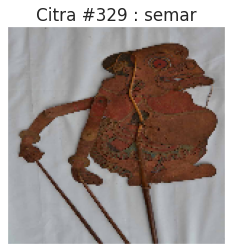

In [16]:
predictions = model.predict(test_images)     # Vector probabilitas
pred_labels = np.argmax(predictions, axis = 1) # Mengambil probabilitas tertingi

display_random_image(class_names, test_images, pred_labels)

# Analisa Error

In [17]:
# Kita cek citra mana yang gagal dalam klasifikasi
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):

    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Contoh citra yang gagal dalam klasifikasi:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

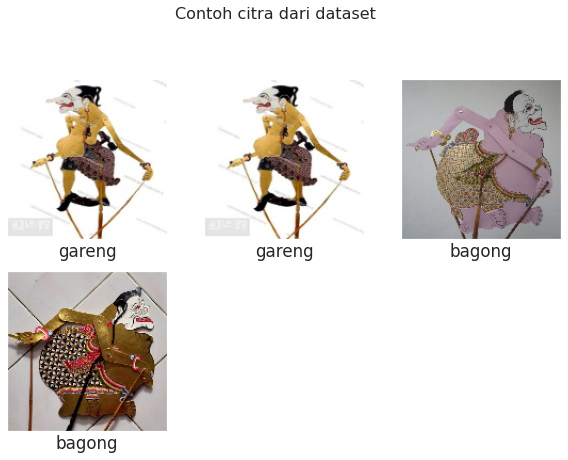

In [18]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)


Classification Report :

               precision    recall  f1-score   support

       arjuna       0.97      1.00      0.98        30
       bagong       0.93      0.93      0.93        30
bathara surya       1.00      1.00      1.00        30
bathara wisnu       1.00      1.00      1.00        30
       gareng       0.94      1.00      0.97        30
       nakula       1.00      1.00      1.00        30
       sadewa       1.00      1.00      1.00        30
       petruk       1.00      0.93      0.97        30
        semar       0.97      0.93      0.95        30
    werkudara       1.00      1.00      1.00        30
    yudistira       1.00      1.00      1.00        30

     accuracy                           0.98       330
    macro avg       0.98      0.98      0.98       330
 weighted avg       0.98      0.98      0.98       330



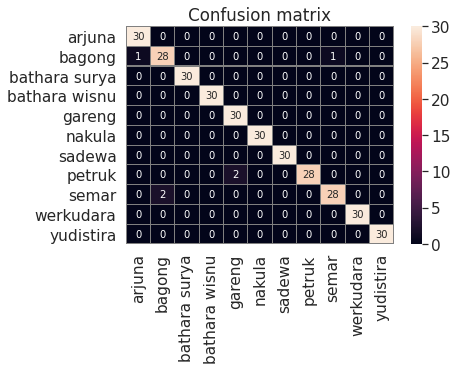

In [19]:
# membuat confusion matrix
CM = confusion_matrix(test_labels, pred_labels)
CR = classification_report(test_labels, pred_labels, target_names=class_names)
print("\nClassification Report :\n")
print(CR)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           linewidths=0.1, 
           linecolor='gray',
           annot_kws={"size": 10},
           xticklabels=class_names, 
           yticklabels=class_names, 
           ax = ax)
ax.set_title('Confusion matrix')
plt.savefig('/content/drive/MyDrive/Klasifikasi Wayang Kulit/asset_e10/plot_Confusion_Matrix.png')
plt.show()

# Feature extraction dengan VGG16

Feature extraction merupakan salah satu cara untuk mengenali suatu objek dengan melihat ciri-ciri khusus yang dimiliki objek tersebut. Tujuan dari feature extraction adalah melakukan perhitungan dan perbandingan yang bisa digunakan untuk mengklasifikasikan ciri-ciri yang dimiliki oleh suatu citra

In [20]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [21]:
# Mendapatkan fitur dari model vgg16
train_features = model.predict(train_images)
test_features = model.predict(test_images)

# Visualisasikan fitur melalui PCA

In [22]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [23]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Representasi individu dalam sumbu baru
C1 = C[:,0]
C2 = C[:,1]

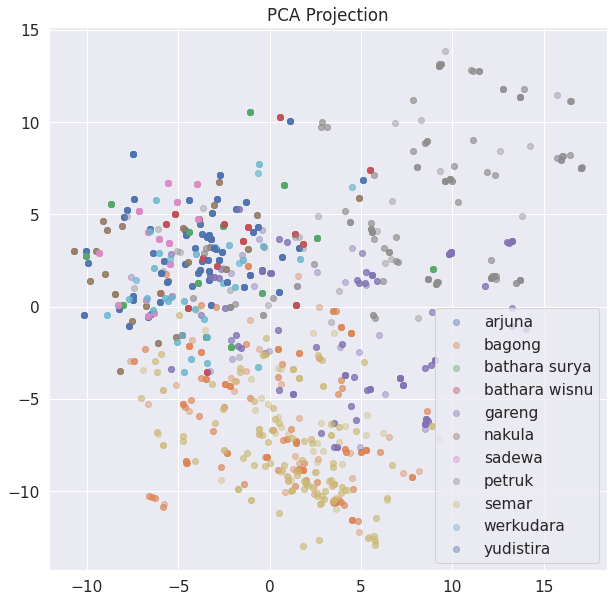

In [24]:
# Figures
plt.subplots(figsize=(10,10))
for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.title("PCA Projection")
plt.legend()
plt.savefig('/content/drive/MyDrive/Klasifikasi Wayang Kulit/asset_e10/plot_PCA.png')
plt.show()

# Membuat Model on top VGG16

In [25]:
%%time

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

#Training model on top VGG16
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(11, activation=tf.nn.softmax)
])
model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', 
               metrics=['accuracy'])
history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=10, 
                      validation_split = 0.2)

Epoch 1/10
12/12 [==============================] - 1s 21ms/step - loss: 1.4736 - accuracy: 0.5608 - val_loss: 0.5940 - val_accuracy: 0.8649
Epoch 2/10
12/12 [==============================] - 0s 13ms/step - loss: 0.3873 - accuracy: 0.9196 - val_loss: 0.2675 - val_accuracy: 0.9486
Epoch 3/10
12/12 [==============================] - 0s 12ms/step - loss: 0.1680 - accuracy: 0.9669 - val_loss: 0.1627 - val_accuracy: 0.9622
Epoch 4/10
12/12 [==============================] - 0s 12ms/step - loss: 0.0884 - accuracy: 0.9919 - val_loss: 0.1139 - val_accuracy: 0.9865
Epoch 5/10
12/12 [==============================] - 0s 13ms/step - loss: 0.0586 - accuracy: 0.9946 - val_loss: 0.0972 - val_accuracy: 0.9892
Epoch 6/10
12/12 [==============================] - 0s 14ms/step - loss: 0.0446 - accuracy: 0.9932 - val_loss: 0.0775 - val_accuracy: 0.9838
Epoch 7/10
12/12 [==============================] - 0s 12ms/step - loss: 0.0303 - accuracy: 0.9959 - val_loss: 0.0735 - val_accuracy: 0.9892
Epoch 8/10
12

In [26]:
# simpan model2
filename = '/content/drive/MyDrive/Klasifikasi Wayang Kulit/model_e10/model_ontopVGG16.h5'
model2.save(filename)
#print('>Saved model to %s' % filename)

# simpan model2 report ke csv
model_csv = pd.DataFrame(history2.history)
csv_file = '/content/drive/MyDrive/Klasifikasi Wayang Kulit/model_e10/model_ontopVGG16.csv'
with open(csv_file, mode="w") as f:
  model_csv.to_csv(f)
#print('>Saved report to %s' % csv_file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                409650    
_________________________________________________________________
dense_3 (Dense)              (None, 11)                561       
Total params: 410,211
Trainable params: 410,211
Non-trainable params: 0
_________________________________________________________________


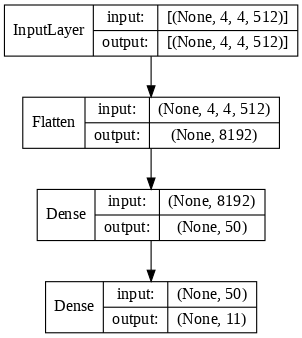

In [27]:
model2.summary()
plot_model(model2, to_file='/content/drive/MyDrive/Klasifikasi Wayang Kulit/asset_e10/model_VGG16.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80)

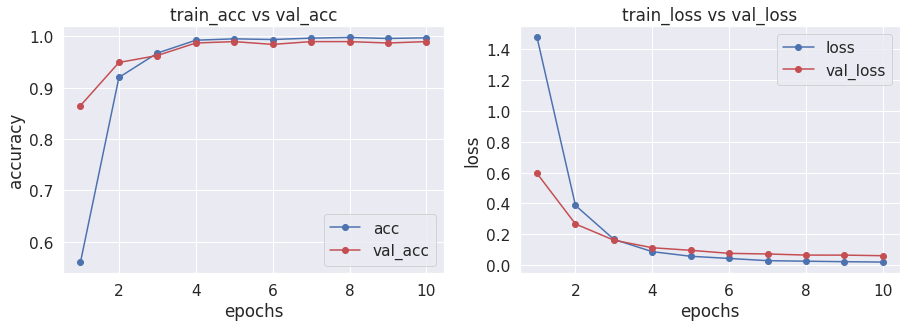

In [28]:
def plot_accuracy_loss_vgg16(history2):
    plt.figure(figsize=(15,10))
    epochs2 = range(1, len(history2.history['accuracy']) + 1)
    # Plot accuracy
    plt.subplot(221)
    plt.plot(epochs2, history2.history['accuracy'],'bo-', label = "acc")
    plt.plot(epochs2, history2.history['val_accuracy'], 'ro-', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    # Plot loss function
    plt.subplot(222)
    plt.plot(epochs2, history2.history['loss'],'bo-', label = "loss")
    plt.plot(epochs2, history2.history['val_loss'], 'ro-', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.savefig('/content/drive/MyDrive/Klasifikasi Wayang Kulit/asset_e10/plot_VGG16.png')
    plt.show()
plot_accuracy_loss_vgg16(history2)

In [29]:
test_loss, test_acc = model2.evaluate(test_features, test_labels)
print("Accuracy : {:.2f}%".format(test_acc*100))
print("Loss     : {:.3f}".format(test_loss))

11/11 [==============================] - 0s 3ms/step - loss: 0.0350 - accuracy: 0.9970
Accuracy : 99.70%
Loss     : 0.035


In [30]:
# END